In [1]:
import pandas as pd

# Load the data from the file into a DataFrame
file_path = 'data/20240102180106.txt'
df = pd.read_csv(file_path, sep='\t')  # Assuming the separator is a tab, as common in such data logs

In [2]:
data = pd.DataFrame()
data[['acc_X(g)', 'acc_Y(g)', 'acc_Z(g)', 'Time']] = df[['加速度X(g)', '加速度Y(g)', '加速度Z(g)', '时间']]

In [3]:
data

,acc_X(g),acc_Y(g),acc_Z(g),Time
0,-0.388,0.784,0.486,2024-1-2 18:1:7:17
1,-0.388,0.783,0.485,2024-1-2 18:1:7:138
2,-0.388,0.784,0.486,2024-1-2 18:1:7:225
3,-0.388,0.784,0.486,2024-1-2 18:1:7:343
4,-0.387,0.783,0.486,2024-1-2 18:1:7:435
...,...,...,...,...
4635,0.564,0.808,0.180,2024-1-2 18:39:16:948
4636,0.573,0.821,0.183,2024-1-2 18:39:17:12
4637,0.573,0.808,0.177,2024-1-2 18:39:17:162
4638,0.563,0.806,0.174,2024-1-2 18:39:17:251


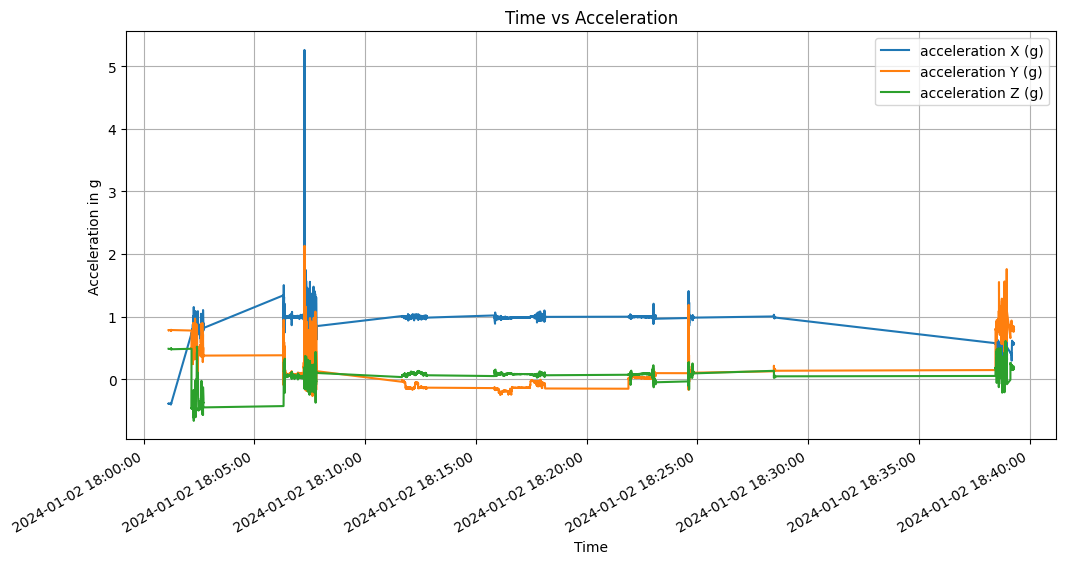

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Adjusting the datetime parsing to accommodate the specific format of the timestamps
# The format seems to be 'year-month-day hour:minute:second:millisecond'
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S:%f')

# Re-plotting
plt.figure(figsize=(12, 6))

# Plotting each acceleration component
plt.plot(data['Time'], data['acc_X(g)'], label='acceleration X (g)')
plt.plot(data['Time'], data['acc_Y(g)'], label='acceleration Y (g)')
plt.plot(data['Time'], data['acc_Z(g)'], label='acceleration Z (g)')

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('Acceleration in g')
plt.title('Time vs Acceleration')
plt.legend()
plt.grid(True)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate() # Auto format for better date representation
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Show the plot
plt.show()



这段代码将会生成一个散点图矩阵，显示了 x，y 和 z 这三个特征之间的关系，不同的颜色表示不同的聚类。由于数据集可能很大，所以我们随机抽取了一部分数据进行可视化。如果你希望可视化更多的数据，可以调整 min(5000, len(data_clustered)) 这一行中的 5000 这个数字。

### K-means

In [5]:
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler

# 假设 df 是包含您数据的 pandas DataFrame
# 加载数据


# 选择加速度数据
acceleration_data = data[['acc_X(g)', 'acc_Y(g)', 'acc_Z(g)']]

# 数据预处理：标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(acceleration_data)

# 时间序列数据通常需要特定的预处理
# 这里我们使用 TimeSeriesScalerMeanVariance 将时间序列标准化为平均值为0，方差为1
scaled_data = TimeSeriesScalerMeanVariance().fit_transform(scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1], 1))

# 使用 K-均值聚类
n_clusters = 3  # 假设我们希望将数据分成3类
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10)

# 训练模型
model.fit(scaled_data)

# 预测聚类标签
labels = model.predict(scaled_data)

# 将聚类结果添加到原始 DataFrame
data['Cluster'] = labels

# 现在 data 包含了每个时间点数据的聚类标签


/home/codespace/.python/current/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [6]:
data['Cluster'].value_counts()

Cluster
0    2948
2     982
1     710
Name: count, dtype: int64

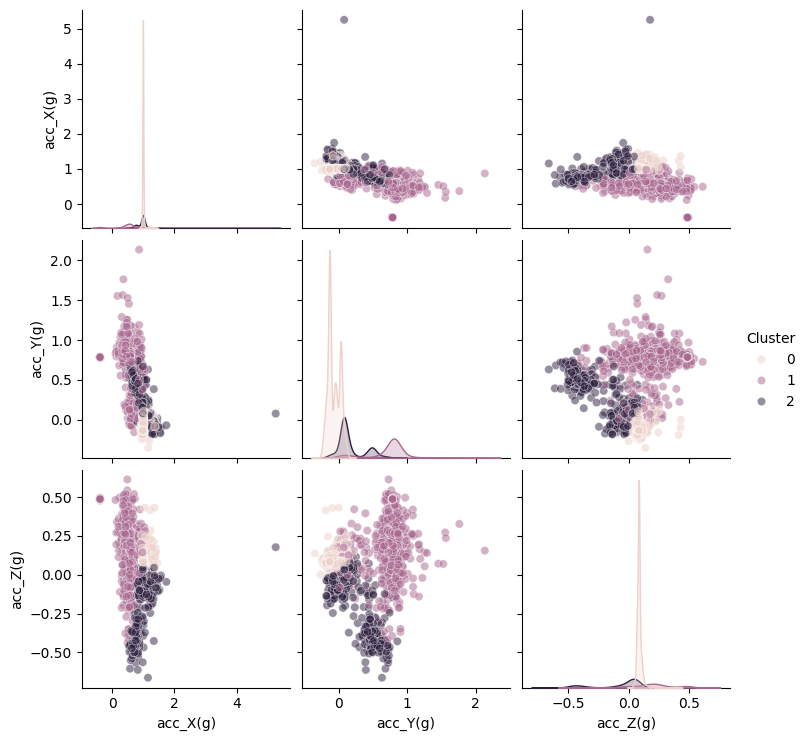

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the clustered data
data_clustered = data

# Due to the potential large size of the dataset, we randomly sample a subset for visualization
data_sample = data_clustered.sample(n=min(5000, len(data_clustered)), random_state=1)

# Create a pairplot colored by the cluster assignment
sns.pairplot(data_sample, vars=['acc_X(g)', 'acc_Y(g)', 'acc_Z(g)'], hue='Cluster', plot_kws={'alpha': 0.5})
plt.show()

In [8]:
data.to_csv('data/20240102180106_clustered.txt', sep='\t', index=False)

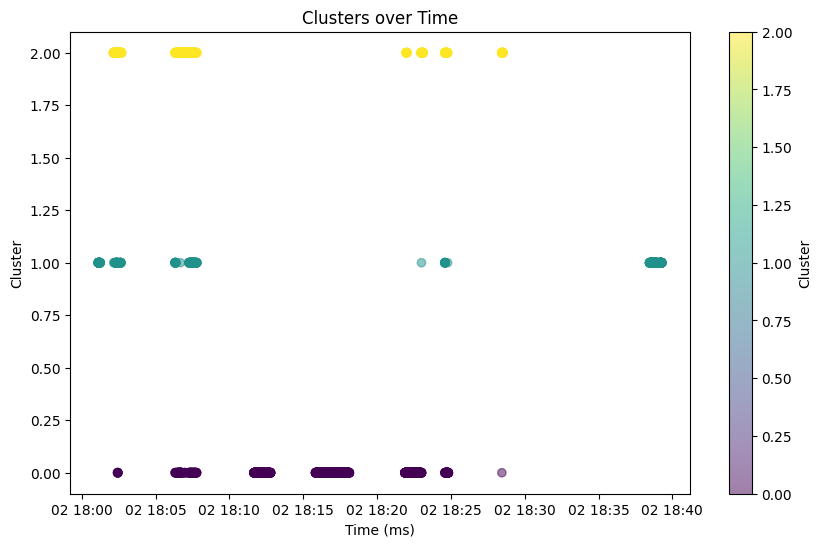

In [9]:
import matplotlib.pyplot as plt

# Load the clustered data
data_clustered

# Create a scatter plot
plt.figure(figsize=(10,6))
scatter = plt.scatter(data_clustered['Time'], data_clustered['Cluster'], c=data_clustered['Cluster'], alpha=0.5)
plt.title('Clusters over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Cluster')
plt.colorbar(scatter, label='Cluster')
plt.show()

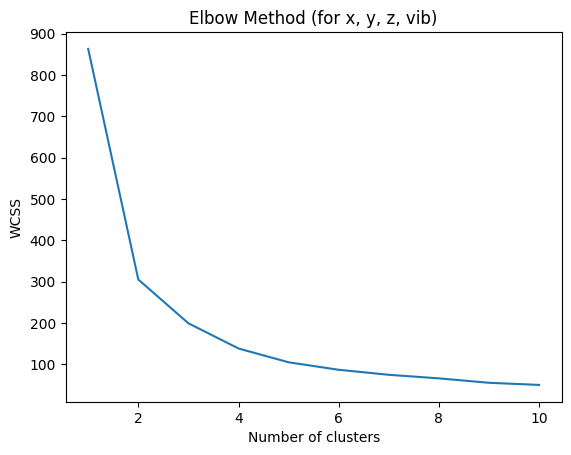

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Prepare the data by selecting the x, y, z columns
data_xyz = data[['acc_X(g)', 'acc_Y(g)', 'acc_Z(g)']]

# Use the Elbow Method to find the optimal number of clusters
wcss_xyz = []  
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_xyz)
    wcss_xyz.append(kmeans.inertia_)

# Plot the results
plt.plot(range(1, 11), wcss_xyz)
plt.title('Elbow Method (for x, y, z, vib)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

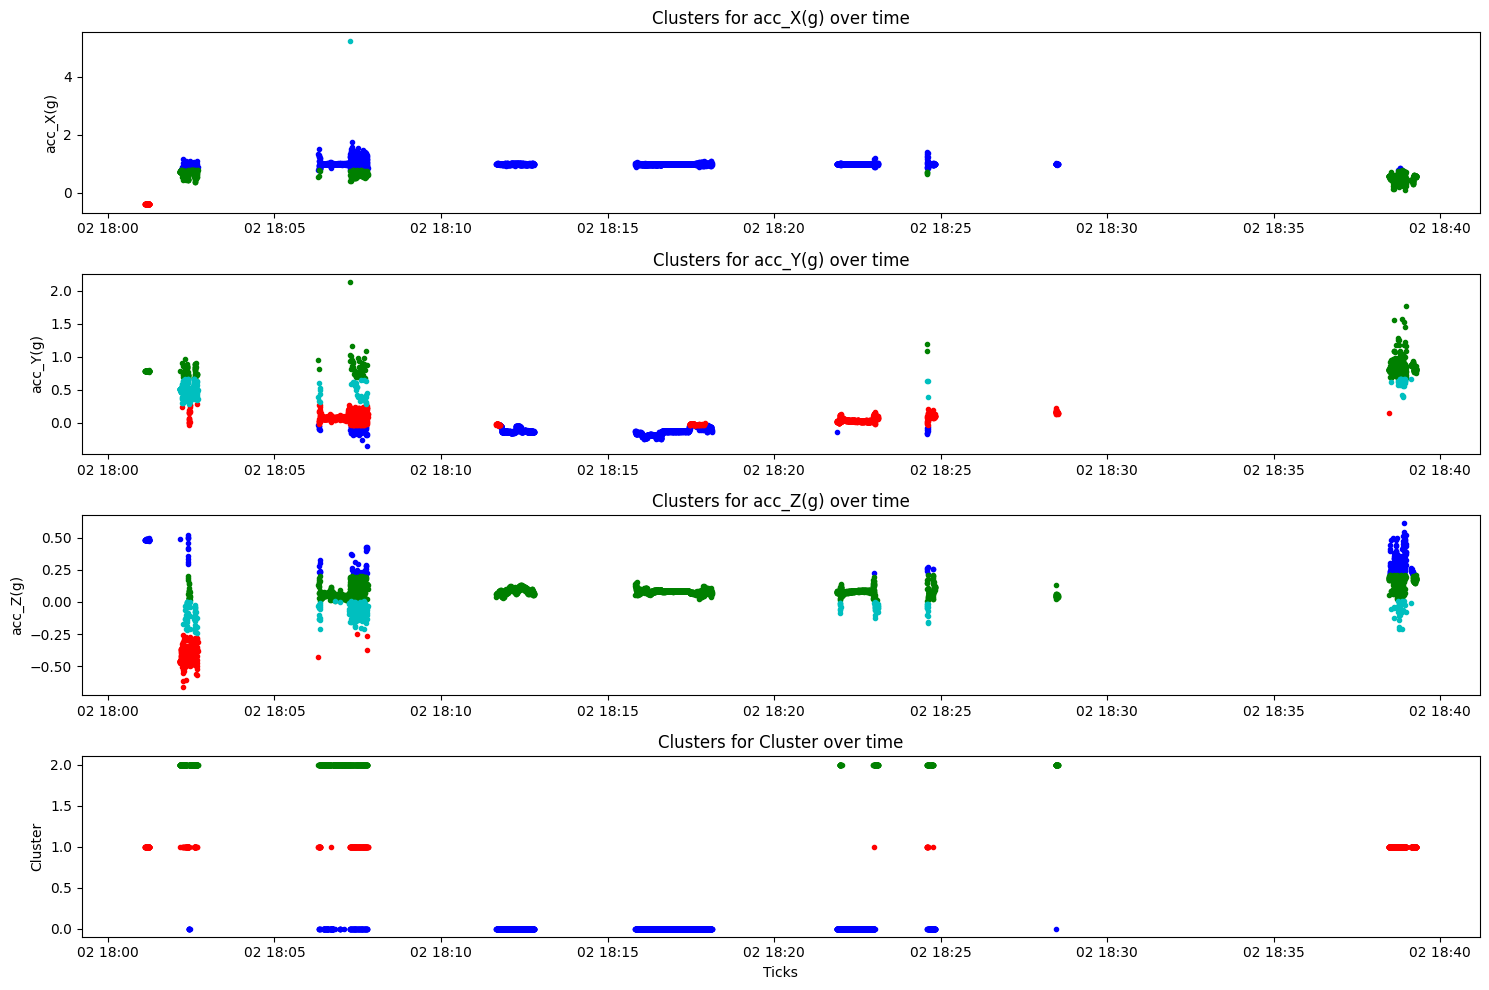

In [12]:
import matplotlib.pyplot as plt


# Prepare the data and create a KMeans instance with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)

features = ['acc_X(g)', 'acc_Y(g)', 'acc_Z(g)', 'Cluster']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots(len(features), 1, figsize=(15, 10))

# Apply KMeans for each feature and plot
for i, feature in enumerate(features):
    feature_data = data[feature].values.reshape(-1,1)
    kmeans.fit(feature_data)
    clusters = kmeans.predict(feature_data)
    for cluster in set(clusters):
        ax[i].plot(data.Time[clusters == cluster], data[feature][clusters == cluster], '.', color=colors[cluster])
    ax[i].set_title(f'Clusters for {feature} over time')
    ax[i].set_ylabel(feature)


#ax[len(features)].plot(data.Time, clusters, color=colors[cluster])


plt.xlabel('Ticks')
plt.tight_layout()
plt.show()


/tmp/ipykernel_992/780914438.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_992/780914438.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_992/780914438.py:24: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_992/780914438.py:24: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_992/780914438.py:24: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_992/780914438.py:24: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_992/780914438.py:24: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/tmp/i

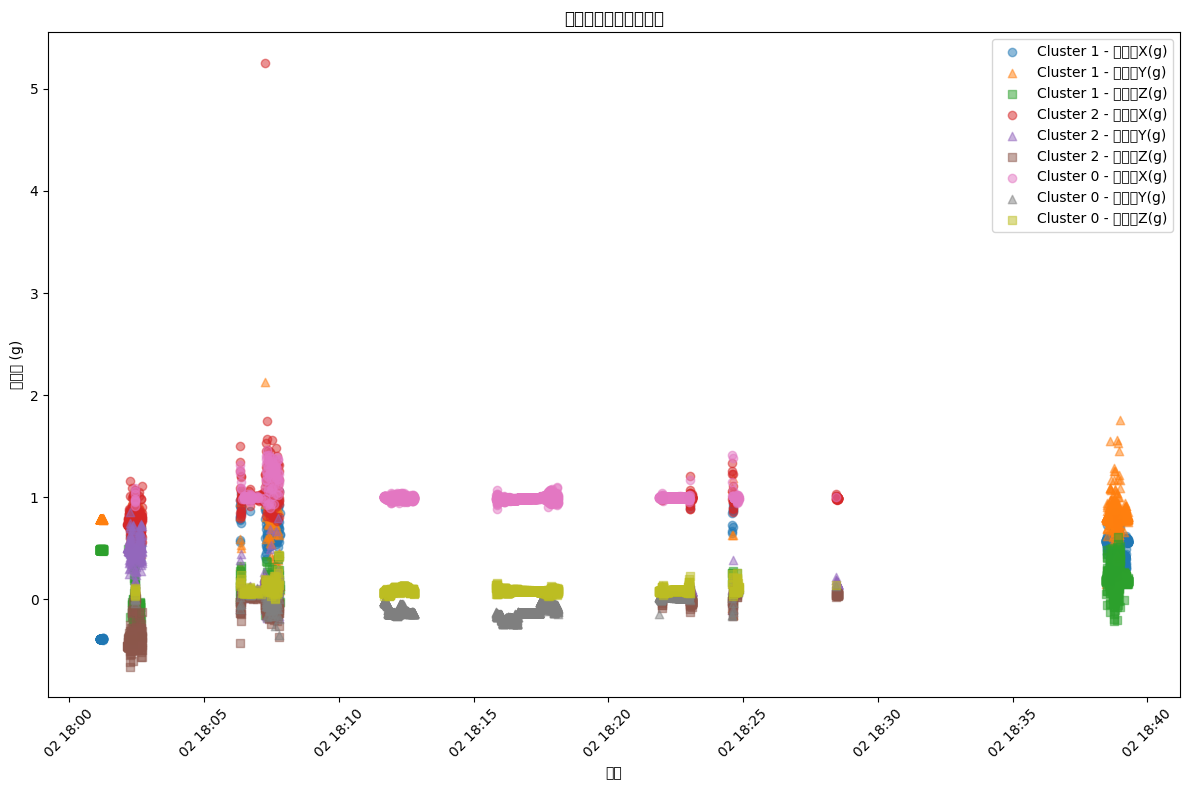

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Re-importing the file and converting the time column to datetime format for plotting
df = data
# Plotting scatter chart with time on x-axis and accelerations on y-axis, color-coded by Cluster
plt.figure(figsize=(12, 8))

# Creating a scatter plot for each acceleration dimension
# To avoid the issue with multiple values for 'label', we plot each dimension separately
for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Time'], cluster_data['acc_X(g)'], label=f'Cluster {cluster} - 加速度X(g)', alpha=0.5)
    plt.scatter(cluster_data['Time'], cluster_data['acc_Y(g)'], marker='^', label=f'Cluster {cluster} - 加速度Y(g)', alpha=0.5)
    plt.scatter(cluster_data['Time'], cluster_data['acc_Z(g)'], marker='s', label=f'Cluster {cluster} - 加速度Z(g)', alpha=0.5)

# Improving plot aesthetics
plt.xlabel('时间')
plt.ylabel('加速度 (g)')
plt.title('加速度与时间的关系图')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Showing the plot
plt.show()
